In [1]:
'''
https://github.com/vedantagarwal4
'''

'\nhttps://github.com/vedantagarwal4\n'

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import tensorflow as tf
seed = 1

In [22]:
datafile = os.path.join( os.getcwd(), "Clean Data")
datafile = os.path.join( datafile, "data.csv")

df = pd.read_csv(datafile)

In [23]:
df.shape, df.label.nunique()

((1392, 2), 26)

In [24]:
# TRAIN-VAL-TEST
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.1, stratify=df.label)
train, validate = train_test_split(train, test_size=0.11, stratify=train.label)

train.shape, validate.shape, test.shape

((1114, 2), (138, 2), (140, 2))

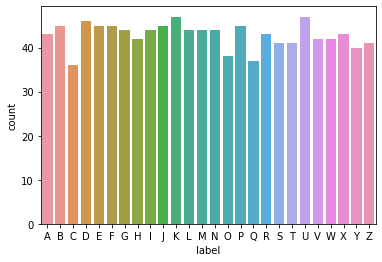

In [25]:
labels = sorted(list(train.label.unique()))

import seaborn as sns
sns.countplot(x='label',data=train, order=labels)

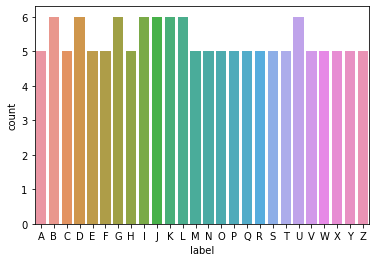

In [26]:
sns.countplot(x='label', data=validate, order=labels)

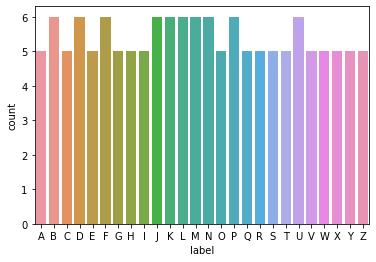

In [27]:
sns.countplot(x='label', data=test, order=labels)

In [28]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [29]:
#AUGMENTATION

batch_size=16
target_size=(100, 100)
color_mode="rgb"

train_datagen = ImageDataGenerator(
        rescale=1./255,
        zoom_range=0.1,
        horizontal_flip=True,
        rotation_range=10,
        width_shift_range = 0.1,
        height_shift_range = 0.1,
        brightness_range = (0.5,1)
)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train,
    directory=None,
    x_col="path",
    y_col="label",
    target_size=target_size,
    color_mode=color_mode,
    class_mode="categorical",
    batch_size=batch_size,
    #save_to_dir = "preview",
    #save_prefix = "preview",
    #save_format = "png"
)

test_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = test_datagen.flow_from_dataframe(
    dataframe=validate,
    directory=None,
    x_col="path",
    y_col="label",
    target_size=target_size,
    color_mode=color_mode,
    class_mode="categorical",
    batch_size=batch_size,
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test,
    directory=None,
    x_col="path",
    y_col="label",
    target_size=target_size,
    color_mode=color_mode,
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=False
)

Found 1114 validated image filenames belonging to 26 classes.
Found 138 validated image filenames belonging to 26 classes.
Found 140 validated image filenames belonging to 26 classes.


In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense

In [31]:
#SHALLOW CNN
def create_cnn( d=0, bn=False, pad='valid', n_l=64, L=1):
    
    model = Sequential()
    
    model.add(Conv2D(32, (3, 3), padding=pad, input_shape=(100, 100, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    if bn==True:
        model.add(BatchNormalization())

    model.add(Conv2D(64, (3, 3), padding=pad))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    if bn==True:
        model.add(BatchNormalization())
    
    model.add(Conv2D(64, (3, 3), padding=pad))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    if bn==True:
        model.add(BatchNormalization())

    model.add(Flatten())
    
    for i in range(L):    
        model.add(Dense(n_l))
        model.add(Activation('relu'))
        model.add(Dropout(d))
        if bn==True:
            model.add(BatchNormalization())

    model.add(Dense(26))
    model.add(Activation('softmax'))

    model.compile(
                  loss='categorical_crossentropy', #becase this is not a multilabel dataset.
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, amsgrad=True),
                  metrics=['acc','categorical_accuracy']
                )
    
    #model.summary()
    
    return model

In [32]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor = 'val_acc', mode = 'max', patience=25, restore_best_weights=True)

In [33]:
def plot_history(model_hist):
    plt.plot(model_hist.history['loss'], label = 'loss')
    plt.plot(model_hist.history['val_loss'], label = 'val_loss')
    plt.legend()
    plt.show()
    
    plt.plot(model_hist.history['acc'], label = 'acc')
    plt.plot(model_hist.history['val_acc'], label = 'val_acc')
    plt.legend()
    plt.show()

In [34]:
d=[ 0 ]
bn=[False, True]
pad=['valid', 'same']
n_l=[64, 128]
L=[1, 2, 3]
epochs=[150]

param_grid = dict( d=d, bn=bn, pad=pad, n_l=n_l, L=L, epochs=epochs)

param_grid

{'d': [0],
 'bn': [False, True],
 'pad': ['valid', 'same'],
 'n_l': [64, 128],
 'L': [1, 2, 3],
 'epochs': [150]}

In [ ]:
for d in param_grid['d']:
    for bn in param_grid['bn']:
        for pad in param_grid['pad']:
            for n_l in param_grid['n_l']:
                for L in param_grid['L']:
                    for epochs in param_grid['epochs']:
                                 
                        print('---------', d, bn, pad, n_l, L, epochs, '---------')
                                 
                        model = create_cnn( d=d, bn=bn, pad=pad, n_l=n_l, L=L)
                                 
                        train_generator.reset()
                        validation_generator.reset()
                                 
                        model_hist = model.fit( train_generator, 
                                      steps_per_epoch=train.shape[0] // batch_size, 
                                      epochs=epochs,
                                      validation_data=validation_generator, 
                                      validation_steps=validate.shape[0] // batch_size,
                                      callbacks=[early_stop],
                                      verbose=0
                        )
                                 
                        plot_history(model_hist)
                                 
                        test_generator.reset()
                        test_acc = model.evaluate(test_generator)
                                 
                                 